In [556]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import netgraph
import copy
import time

Make Graph

In [557]:
# SET GRAPH PARAMETERS
numNodes = 15
degree = 1   

# MAKE GRAPHS
graph1 = nx.complete_graph(5)
#graph2 = random_regular_graph(degree, numNodes, seed=None)
graph3 = nx.gn_graph(numNodes, None, None, 0)

# INITIALIZE PARAMETERS
# COLOR (also used as visited. blue == not visited, red == visiting, not all edges yet considered, green == visted, all edges visited.)
color_map3 = ["tab:blue"]*len(graph3.nodes)
nx.set_node_attributes(graph3, dict(zip(graph3.nodes(), color_map3)), "color") # for each node, set attribute color to the value in the color map
# DISTANCE (inaccurate and unused. theoretically node distance from initial vertex)
distance_map3 = [None]*len(graph3.nodes)
nx.set_node_attributes(graph3, dict(zip(graph3.nodes(), distance_map3)), "dist") 
# PREVIOUS (the node we came from before to access current node)
previous_map3 = [None]*len(graph3.nodes)
nx.set_node_attributes(graph3, dict(zip(graph3.nodes(), previous_map3)), "prev") 
# LAST TOUCH (the timestep node is left for the last time)
last_touch_map3 = [None]*len(graph3.nodes)
nx.set_node_attributes(graph3, dict(zip(graph3.nodes(), last_touch_map3)), "last_touch") 

# MAKE COPIES OF THE GRAPH
dfsGraph = copy.deepcopy(graph3) # copy of the graph for dfs topological sort algorithm
bfsGraph = copy.deepcopy(graph3) # copy of the graph for bfs topological sort algorithm

Print Generated Graph

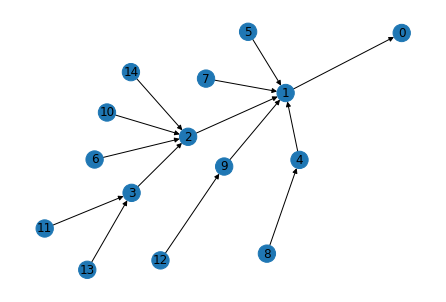

In [558]:
# PRINT GRAPH
nx.draw(dfsGraph, node_color=nx.get_node_attributes(dfsGraph, 'color').values(), with_labels=True)

Run DFS Topological Sort

In [559]:
# page 53 ln6
# an algorithm for topological sort
# call DFS(G) to compute finishing times f[v] for each vertex v
# as each vertex is finished, insert it onto the front of a linked list
# return the linked list of vertices

# FUNCTION FOR DFS VISITING
def dfsVisit(node, graph, timestep, topoList):
    timestep = timestep + 1
    nx.set_node_attributes(graph, {node:"tab:red"}, "color")
    nx.set_node_attributes(graph, {node:timestep}, "dist")
    for subnode in graph.successors(node):
        if(nx.get_node_attributes(graph, 'color')[subnode]=='tab:blue'): # means we didn't visit the child before
            nx.set_node_attributes(graph, {subnode:node}, "prev")
            topoList, nodeUnused, timestep = dfsVisit(subnode, graph, timestep, topoList)
    nx.set_node_attributes(graph, {node:"tab:green"}, "color") # at this point we have considered all edges
    timestep = timestep + 1
    nx.set_node_attributes(graph, {node:timestep}, "last_touch") # at this point we have considered all edges
    topoList.append(node)
    return topoList, node, timestep


# RUN DFS TOPOLOGICAL SORT
def dfsTopo(dfsGraph, displayGraph):
    timestep = 0
    # randomize the list of nodes in the graph before looping through them. This reduces the likelyhood of simply traversing the graph from the bottom up, making toposort less interesting
    randomizedDFSGraphNodes = list(dfsGraph.nodes)
    random.shuffle(randomizedDFSGraphNodes) # our randomized list of all nodes in the graph
    topoList = [] # will store our topological order of visited nodes
    # BEGIN TIMING
    dfst0 = time.time()
    for node in randomizedDFSGraphNodes: # page 53 lecture note 6
        if not (nx.get_node_attributes(dfsGraph, 'color')[node]=='tab:green'): # means we didn't visit it before
            topoList, nodeUnused, timestep = dfsVisit(node, dfsGraph, timestep, topoList) # run DFS starting from this node, record topological ordering
    # END TIMING
    dfst1 = time.time()
    dfs_runtime = dfst1-dfst0
    
    # PRINT TOPOLOGICALLY SORTED GRAPH
    if(displayGraph==True):
        # the two dictionaries must each have identical keys before new dictionary creation below
        assert(nx.get_node_attributes(dfsGraph, 'last_touch').keys() <= nx.get_node_attributes(dfsGraph, 'prev').keys()) 
        # make node labels including topological sort
        nodeLabelsDictionary = {} # node, previous, last touch
        for key in nx.get_node_attributes(dfsGraph, 'last_touch'):
            prev = nx.get_node_attributes(dfsGraph, 'prev')[key]
            last = nx.get_node_attributes(dfsGraph, 'last_touch')[key]
            nodeLabelsDictionary[key] = "N:" + str(key) + "\nP:" + str(prev) + "\nF:" + str(last)
        #print("Node labels dictionary = " + str(nodeLabelsDictionary))
        # draw simple graph
        nx.draw(dfsGraph, node_color=nx.get_node_attributes(dfsGraph, 'color').values(), with_labels=True)
        # draw graph with more complex labels
        #nx.draw(dfsGraph, node_color=nx.get_node_attributes(dfsGraph, 'color').values(), labels = nodeLabelsDictionary, with_labels=True)
    return dfs_runtime, topoList

Generate Graphs, run DFS and BFS topo sort

In [560]:
dfs_runtime, DFS_topo_list = dfsTopo(dfsGraph, True)
print("DFS topo list = " + str(DFS_topo_list))
print("Runtime = " + str(dfs_runtime))

DFS topo list = [0, 1, 4, 2, 3, 11, 9, 13, 12, 5, 8, 14, 7, 6, 10]
Runtime = 0.0008101463317871094


Print Graphs After Algorithms

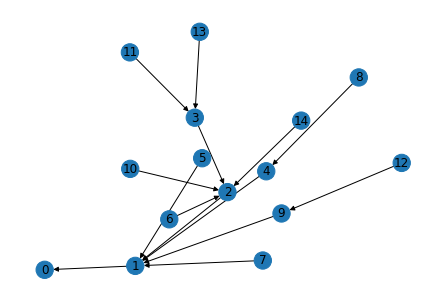

In [561]:
# PRINT GRAPH
nx.draw(graph3, node_color=nx.get_node_attributes(graph3, 'color').values(), with_labels=True)